In [26]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cwnd(filename):
    columns = ['Time', 'Sender', 'Receiver', 'Bytes', 'Next', 'Unack', 'Send_CWND',
               'SS_threshold', 'Send_window', 'Smoothed_RTT', 'Receive_window']
    df = pd.read_csv(filename, sep='\s+', header=None, names=columns)
    df_sender = pd.DataFrame(df['Sender'].str.split(':',1).tolist(), columns=['SenderIP', 'SenderPort'])
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(121)
    ax.set_title(filename.split('/')[-1] + ' conn 1')
    df.loc[df_sender['SenderIP'] == '10.0.0.3'].plot(x='Time', y='Send_CWND', xlim=(0,1000), ax=ax)
    ax = fig.add_subplot(122)
    ax.set_title(filename.split('/')[-1] + ' conn 2')
    df.loc[df_sender['SenderIP'] == '10.0.0.4'].plot(x='Time', y='Send_CWND', xlim=(0,1000), ax=ax)

def get_time_bw(filename):
    df = pd.read_csv(filename, sep='-', header=None, skiprows=6)
    time = pd.DataFrame(df[0].str.split('\s+').tolist())[2]
    time = pd.to_numeric(time)
    # time.head(20)

    df = pd.read_csv(filename, sep='sec', header=None, skiprows=6, engine='python')
    bw = pd.DataFrame(df[1].str.split('\s+').tolist())[3]
    bw = pd.to_numeric(bw)
    # bw.head(20)

    xy = pd.concat([time, bw], axis=1)
    xy.columns = ['time', 'bandwidth']
    xy = xy.loc[xy['bandwidth'] != 0]
    # xy.head(20)
    return xy

def plot_fair(test):
    tcp1 = get_time_bw('data/0405/iperf1_{}.txt'.format(test))
    tcp2 = get_time_bw('data/0405/iperf2_{}.txt'.format(test))
    tcp2['time'] += 250
    ax = tcp1.plot(x='time', y='bandwidth', xlim=(0,1000))
    tcp2.plot(x='time', y='bandwidth', xlim=(0,1000), ax=ax)
    ax.legend(["conn 1", "conn 2"])
    ax.set_ylabel("bandwidth (Mbits/sec)")
    ax.set_title(test)

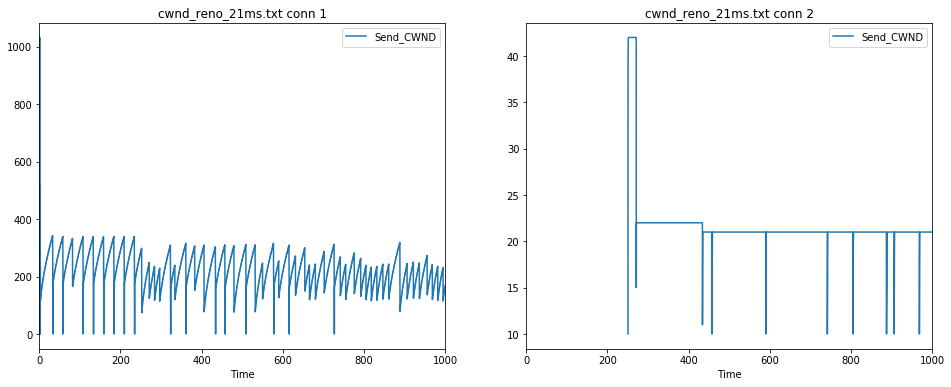

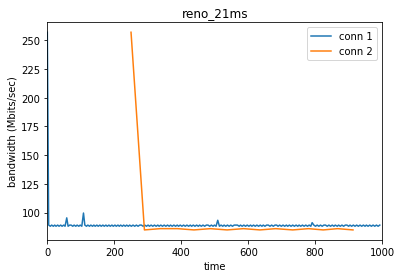

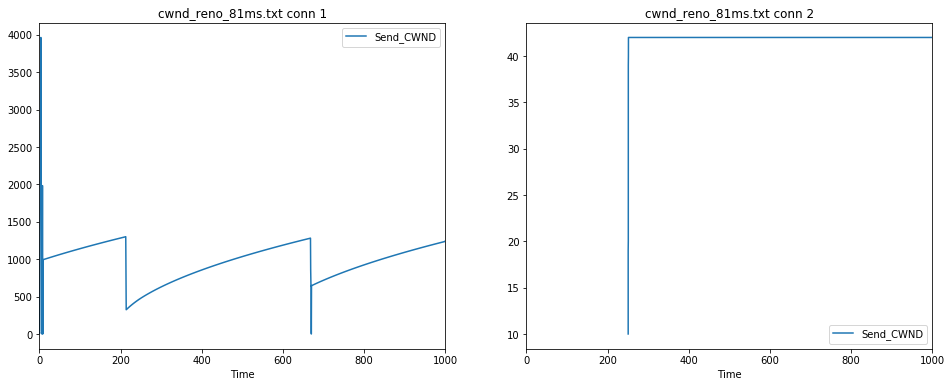

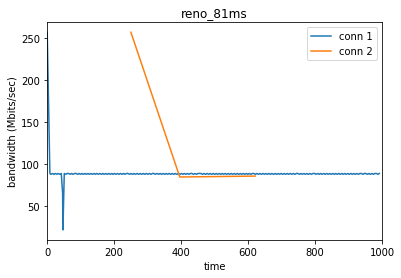

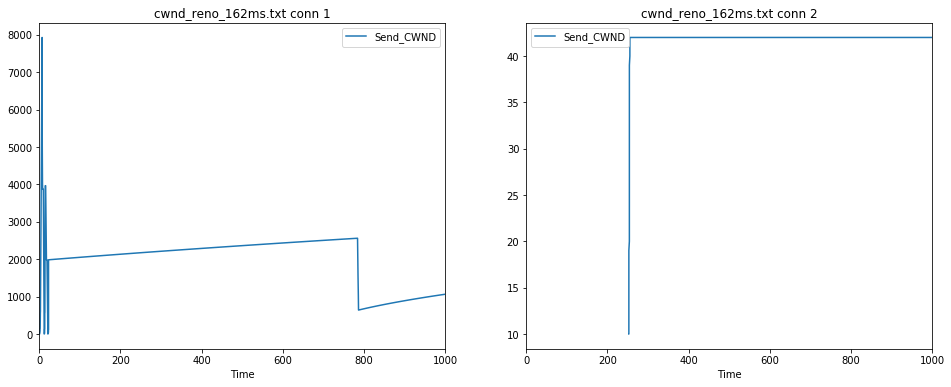

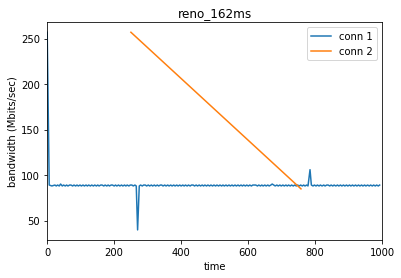

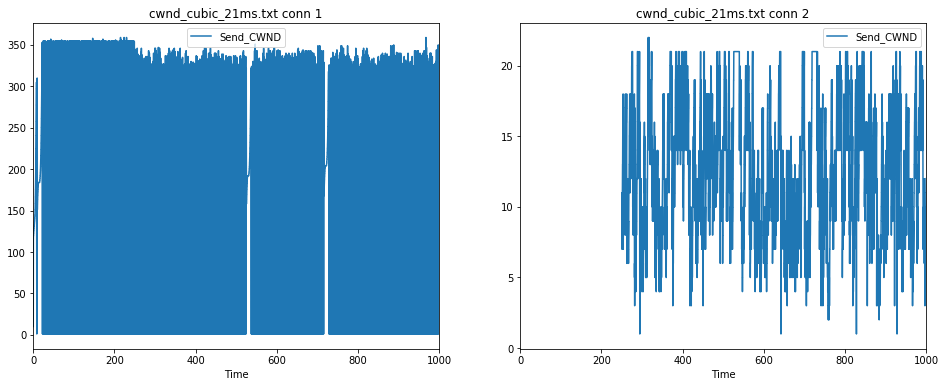

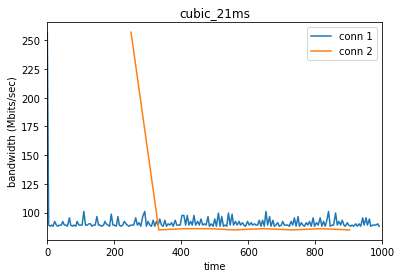

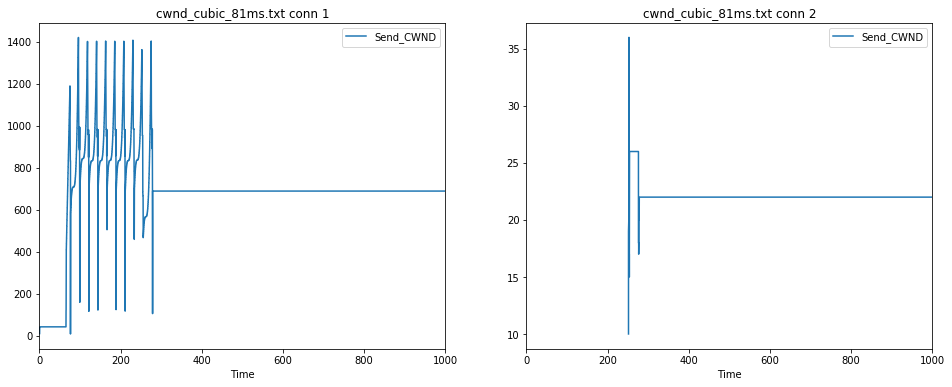

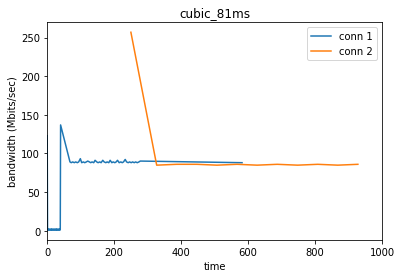

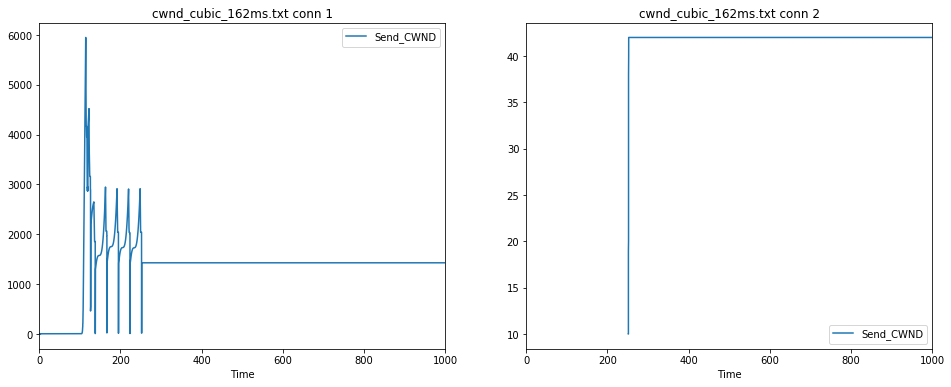

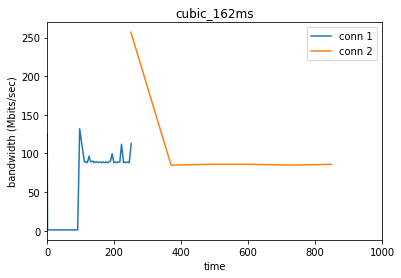

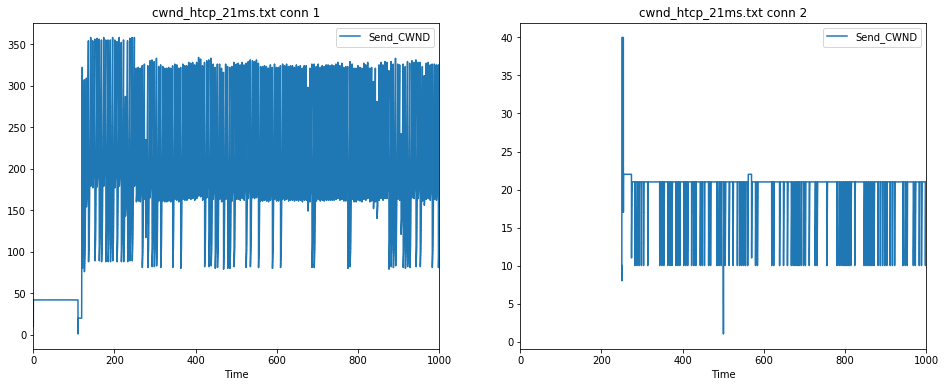

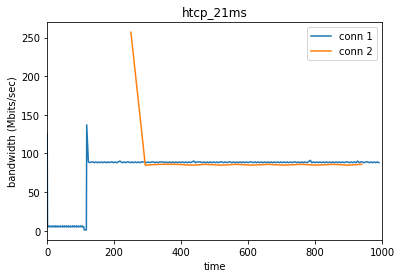

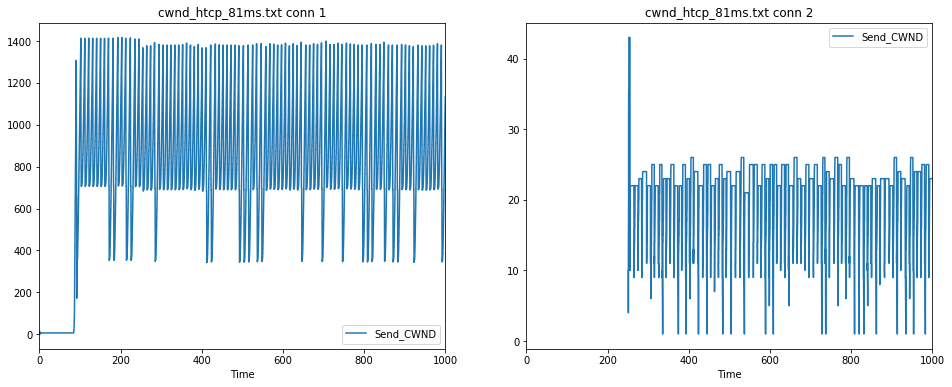

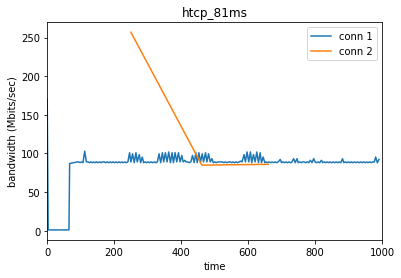

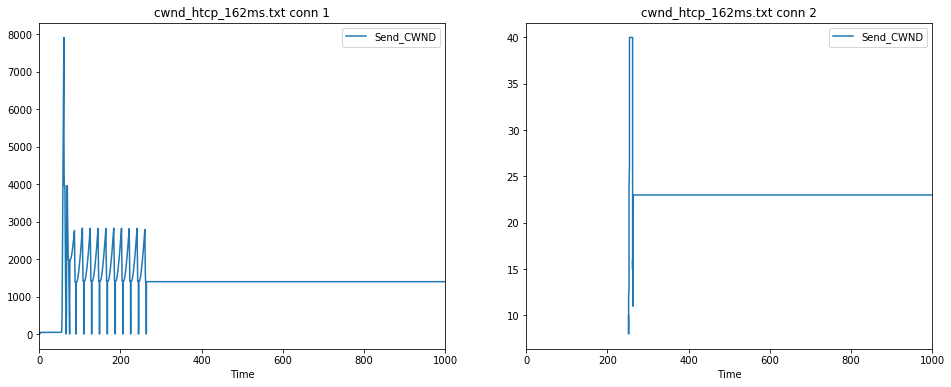

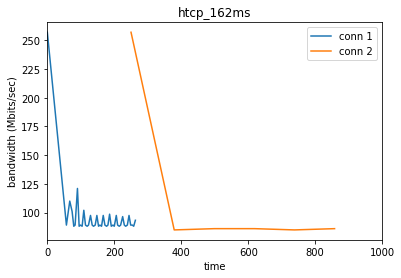

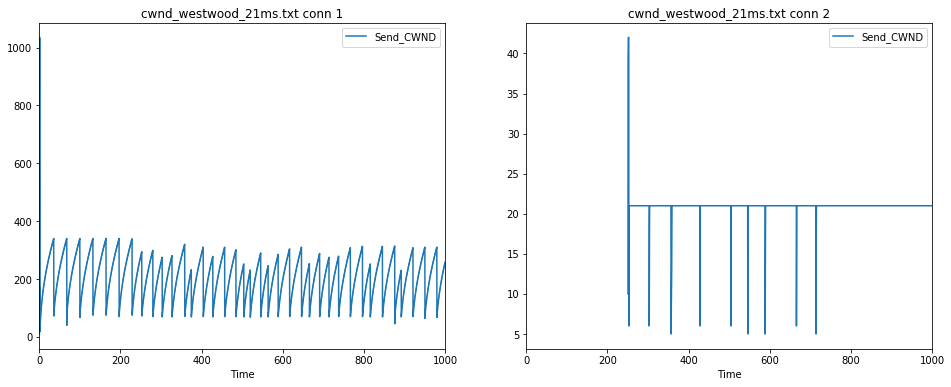

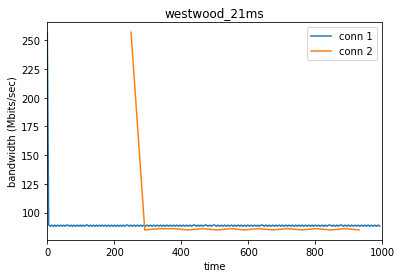

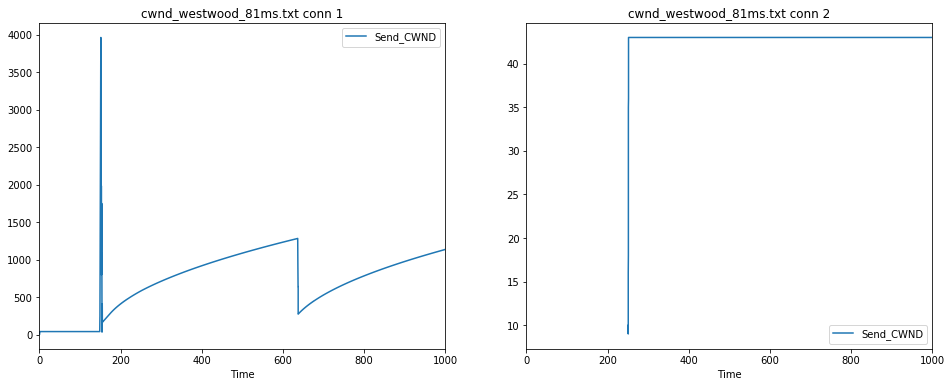

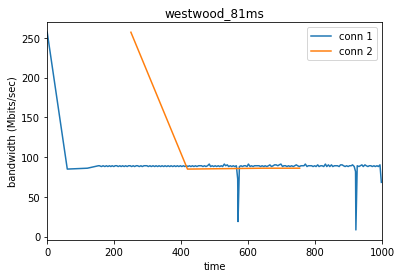

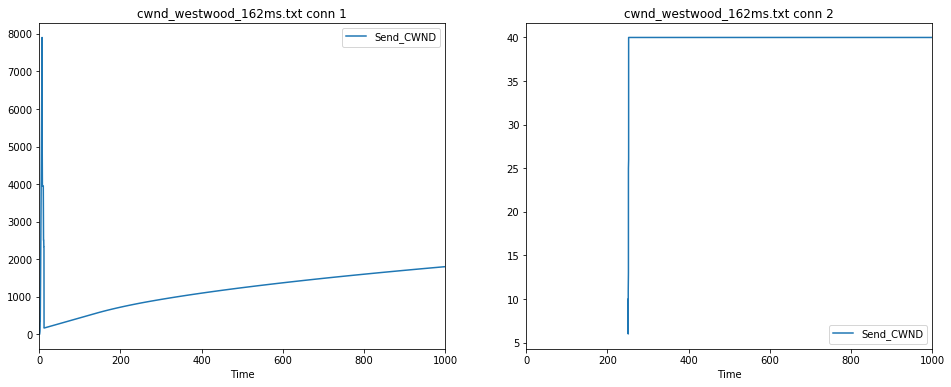

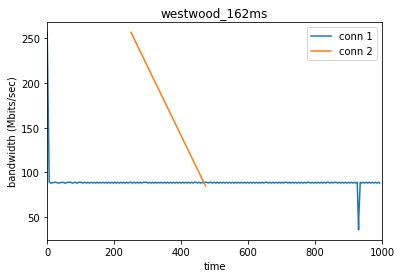

In [27]:
algorithms = ['reno', 'cubic', 'htcp', 'westwood']
delays = ['21ms', '81ms', '162ms']
for alg in algorithms:
    for delay in delays:
        plot_cwnd('data/0405/cwnd_{}_{}.txt'.format(alg, delay))
        plot_fair('{}_{}'.format(alg, delay))

My Mininet code is here https://github.com/JoeXinfa/tcpcc

## reno 21ms

The graph shows the expected behavior of the TCP cwnd, which (after initial slow start
ends with a loss just after the cwnd passes 1000) oscillates in a saw-tooth pattern
between a cwnd of 200 and 40 (average about 300). The bandwidth-delay product is set
with one-way delay (21 ms x 21p/ms =) 441 packets, so the range appropriate.
After the second flow begins (at time 250s) it takes between 50 and 100 s for the cwnd
of the two flows to converge to stable values (200 and 20, respectively).
The left plot is similar to the red line in Figure 5-7 in the NIST book.
Note that the book uses two-way delay to calculate BDP, thus cwnd is twice than here.

There are two "issues" here in the second connection. 1) the cwnd plot looks blocky with spikes.
2) The magnitude 10-40 packets is different from the 100-400 packets in the first connection.
The 10-fold difference is the reason I do not plot them in one figure.

It may be explained by the varying packet size (column *Bytes* in TCP probe output).
I plotted the product (*Bytes* multiplied by *Send CWND*) but it does not look right either.
As the [NIST paper](https://www.nist.gov/document-15389) <strong>assumes</strong>
(page 162, 3rd line to the bottom) 1500-byte packets, I also tried to set packet to fixed size.
However, iperf2 -M option seems only set the maximum segment (packet?) size.
According to [this post](https://www.linuxquestions.org/questions/linux-networking-3/how-to-set-packet-size-for-iperf-in-tcp-4175528766/), TCP performs automatic segmentation of the data stream. And iperf3 --set-mss option should work. But I did not have luck with iperf3 either...

Some classmates have similar problems (in different OSs).
We discussed this in class with TA and decided with go by explaining what we have.

The bandwidth plot shows the two TCP connections convergence to a similar speed (~90 Mbits/sec),
which means the two flows will receive fairly equal average throughputs. This property
of convergence to fairness is a hallmark trait of TCP congestion control.

## reno 81ms

The next scenario begins to show why many researchers believe
standard TCP congestion control procedures are ill-suited to high-speed, long-delay
environments. Here, the 162 ms round-trip propagation delay (rtt) suggests a cwnd of (162 ms x
21p/ms =) 3402 packets. The first flow reaches (and then exceeds) that value during slow start,
which ends with a loss (at cwnd ~ 4000) early in the flow. After the loss, TCP reduces the cwnd
in half (to 2000) and then TCP enters its congestion avoidance regime. Increasing the cwnd with
standard TCP congestion avoidance procedures requires about 200s for the flow to reach its
peak window. After that, each cycle takes about 450s (from 200s to 650s).

The fairness plot shows the two flows converge in 150s (from 250s to 400s). This is faster than
the convergence in Figure 5-8 in the NIST book.


## reno 162ms

Here, the 324 ms round-trip propagation delay (rtt) suggests a cwnd of (324 ms x
21p/ms =) 6804 packets. The first flow reaches (and then exceeds) that value during slow start,
which ends with a loss (at cwnd ~ 8000) early in the flow. After the loss, TCP reduces the cwnd
in half (to 4000) and then TCP enters its congestion avoidance regime. Increasing the cwnd with
standard TCP congestion avoidance procedures requires about 700s (from 50s to 750s)
for the flow to reach its peak window.

The fairness plot shows the two flows converge in 500s (from 250s to 750s). This is faster than
the convergence in Figure 5-9 in the NIST book.

## cubic 21-81-162ms

The NIST book does not test the cubic algorithm.

From my plots, the TCP congestion avoidance cycle is much shorter than the reno above.
They become longer with more delays. The 21ms delay plot is dense because the oscillation
period is ~2s (can see after zoom in). The average cwnds are 250, 750, and 2000 for delays
21ms, 81ms, and 162ms, respectively. This is similar to the reno above.

The connection for 81ms delay is broken at ~600s.
The connection for 162ms delay is broken at ~250s. I don't know why.

The fairness plots show convergence faster than the reno above.

## htcp 21-81-162ms

The cwnd curves look the same as the ones (Figs. 5-28 to 5-30) in the book.
They look similar to the cubic above, but with shorter cycles.

The connection for 162ms delay is broken at ~250s.

The bandwidth convergence is similar, except the one of 81ms looks exceptionly slow.

## westwood 21-81-162ms

The NIST book does not test the westwood algorithm.

From my plots, the cwnd curves look similar to the reno above.

The fairness plots show convergence faster than the reno above.